<h2 align = 'center' > Analyze A/B Test Results </h2>  
<h3 align = 'center' > By Clyde Melton </h3> 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)

Specific programming tasks are marked with a **ToDo** tag. 

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.


<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [1]:
# Importing libraries

import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:


from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

This code is a workaround for getting my summary stats to print. While it worked fine on my local enviroment, after moving the file here, it was broken.

In [3]:
#We are setting the seed to assure you get the same answers on quizzes as we set up

random.seed(42)


<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>

**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [4]:
# Reading in the dataset and taking a look at the top few rows here

ab_data_df = pd.read_csv('ab_data.csv')
ab_data_df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [50]:
# Finding and printing the number of rows in the dataset

num_of_rows = len(ab_data_df)
print("Number of rows:", num_of_rows)

Number of rows: 294478


**c.** The number of unique users in the dataset.

In [51]:
# Finding and printing the number of unique users in the dataset

unique_users = ab_data_df.user_id.nunique()
print("Number of unique users:", unique_users)

Number of unique users: 290584


**d.** The proportion of users converted.

In [7]:
# Finding and printing the proportion of users converted

converted_users = round((ab_data_df.query('converted == 1').user_id.nunique()/ab_data_df.user_id.nunique())*100, 0)
print("Percentage of users converted: ", converted_users, "%")

Percentage of users converted:  12.0 %


12.0

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [8]:
#  Finding and printing the number of times the `new_page` and `treatment` do not correspond.

not_new_treatment = ab_data_df.query('group == "treatment" and landing_page != "new_page"').user_id.nunique()
print("Number of users in treatment group but landing page is not new page: ", not_new_treatment)

Number of users in treatment group but landing page is not new page:  1965


1965

**f.** Do any of the rows have missing values?

In [9]:
# Finding and printing the number of times the `old_page` and `control` do not correspond.

ab_data_missing = ab_data_df.index.isna().sum()

if ab_data_missing == 0:
    print("No missing values in the dataset")
else:
    print("Missing values in the dataset")

No missing values in the dataset


### ToDo 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |

**a.** Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [10]:
# Remove the inaccurate rows, and store the result in a new dataframe df2

df2 = ab_data_df.drop(ab_data_df.query('group == "treatment" & landing_page != "new_page"').index)
df2 = df2.drop(df2.query('group == "control" & landing_page != "old_page"').index)

In [11]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0

df2.query('group == "treatment" & landing_page == "new_page"').user_id.count()

145311

### ToDo 1.3  


**a.** How many unique **user_id**s are in **df2**?

In [12]:
# Finding and printing the number of unique users in df2

df2_unique_users = df2.user_id.nunique()
print(f'The number of unique users in df2 is {df2_unique_users}.')

The number of unique users in df2 is 290584.


**b.** There is one **user_id** repeated in **df2**.  What is it?

In [13]:
# Finding and printing the proportion of users converted

repeated_user_id = df2[df2.user_id.duplicated()].user_id.iloc[0]
print(f'The repeated user id is {repeated_user_id}.')

The repeated user id is 773192.


**c.** Display the rows for the duplicate **user_id**? 

In [14]:
# Finding duplkcate rows in df2

df2[df2.user_id == repeated_user_id]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [15]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 

df2.drop(1899, inplace=True)

# Check again if the row with a duplicate user_id is deleted or not

df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


### ToDo 1.4  
Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>

>**Tip**: The probability  you'll compute represents the overall "converted" success rate in the population and you may call it $p_{population}$.



In [16]:
p_population = df2.converted.mean()
print(f'The conversion probability overall is {p_population}.')

The conversion probability overall is 0.11959708724499628.


**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
p_old = df2[df2.group == 'control'].converted.mean()
print(f'The conversion probability for the control group is {p_old}.')

The conversion probability for the control group is 0.1203863045004612.


**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
p_new = df2[df2.group == 'treatment'].converted.mean()
print(f'The conversion probability for the treatment group is {p_new}.')

The conversion probability for the treatment group is 0.11880806551510564.


>**Tip**: The probabilities you've computed in the points (b). and (c). above can also be treated as conversion rate. 
Calculate the actual difference  (`obs_diff`) between the conversion rates for the two groups. You will need that later.  

In [19]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.

obs_diff = p_new - p_old

print(f'The observed difference between the conversion rates for the treatment and control groups is {obs_diff}')

The observed difference between the conversion rates for the treatment and control groups is -0.0015782389853555567


**d.** What is the probability that an individual received the new page?

In [20]:
# Calcuating the probability of an individual receiving the new page

new_page_probability = (df2['landing_page'] == "new_page").mean()

print(f'The probability of an individual receiving the new page is {new_page_probability}')

The probability of an individual receiving the new page is 0.5000619442226688


**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

The increase in coversion rate from the old paage to the new page is 0.68%. While this is an an increase, it is not large enough to make any concrete deductions in favor of rolling out the new site. The new page leading to more significantly more conversions is not demonstrated by the data available.

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
For now, consider you need to make the decision just based on all the data provided.  


If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

$H_0$: $p_{new}$ - $p_{old}$ <= 0

$H_1$: $p_{new}$ - $p_{old}$ > 0

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, you will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 



Use the cells below to provide the necessary parts of this simulation.  You can use **Quiz 5** in the classroom to make sure you are on the right track.

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [21]:
p_new = p_population
print(f'The conversion probability for the new page is {p_new}')

The conversion probability for the new page is 0.11959708724499628


**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [22]:
p_old = p_population
print(f'The conversion probability for the old page is {p_old}')

The conversion probability for the old page is 0.11959708724499628


**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>
*Hint*: The treatment group users are shown the new page.

In [23]:
n_new = df2[df2.landing_page == 'new_page'].shape[0]

print(f'The number of individuals receiving the new page is {n_new}')

The number of individuals receiving the new page is 145310


**d.** What is $n_{old}$, the number of individuals in the control group?

In [24]:
n_old = df2[df2.landing_page == 'old_page'].shape[0]

print(f'The number of individuals receiving the old page is {n_old}')

The number of individuals receiving the old page is 145274


**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>
*Hint*: Use `numpy.random.choice()` method to randomly generate $n_{new}$ number of values. <br>
Store these $n_{new}$ 1's and 0's in the `new_page_converted` numpy array.


In [25]:
# Simulate a Sample for the treatment Group

new_page_converted = np.random.choice([1, 0], size = n_new, p = [p_new, 1 - p_new])
new_page_converted

array([0, 0, 0, ..., 0, 0, 1])

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [26]:
# Simulate a Sample for the control Group

old_page_converted = np.random.choice([1, 0], size = n_old, p = [p_old, 1 - p_old])
old_page_converted

array([0, 0, 1, ..., 0, 0, 0])

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [27]:
new_page_converted.mean() - old_page_converted.mean()

0.0009752080166933463


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [28]:
# Simulate 10,000 p_new - p_old values using this same process above and store all 10,000 values in a NumPy array called p_diffs.

p_diffs = []
for index in range(10000):
    new_page_converted = np.random.choice([0, 1], size = n_new, p = [(1 - p_new), p_new])
    old_page_converted = np.random.choice([0, 1], size = n_old, p = [(1 - p_old), p_old])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

In [29]:
# Covnvert p_diffs to a numpy array

p_diffs = np.asarray(p_diffs)

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  


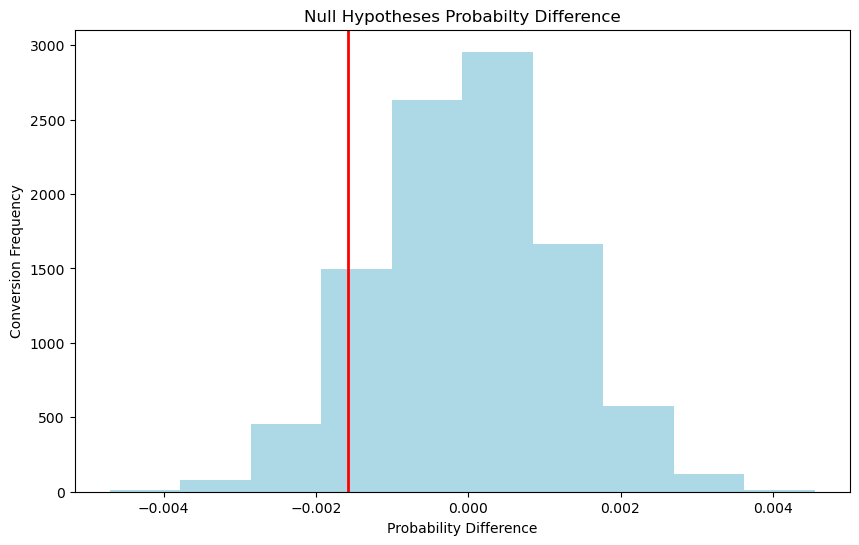

In [30]:
# Plot the sampling distribution

plt.figure(figsize = (10, 6))
plt.hist(p_diffs, color ='lightblue')
plt.title('Null Hypotheses Probabilty Difference')
plt.xlabel('Probability Difference')
plt.ylabel('Conversion Frequency')
plt.axvline(obs_diff, color ='red', linewidth = 2)
plt.show()

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [31]:
print(f'The difference between the p_diff and obs_diff values is {(p_diffs >= obs_diff).mean()}')

The difference between the p_diff and obs_diff values is 0.9027


**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 

The difference between the p_diffs and the observed difference is called the p_value.  

Since the p_value is greater than the Type I error rate of 0.05, we fail to reject the null hypothesis.
This means that we must assume the new page does not lead to more conversions than the old page.



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [32]:
# number of conversions with the old_page
convert_old = df2.query('group == "control" & converted == 1')['converted'].count()

# number of conversions with the new_page
convert_new = df2.query('group == "treatment" & converted == 1')['converted'].count()

# number of individuals who were shown the old_page
n_old = df2.query('landing_page == "old_page"')['landing_page'].count()

# number of individuals who received new_page
n_new = df2.query('landing_page == "new_page"')['landing_page'].count()

**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
>**Hint**: <br>
It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. 
>Hint:<br>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 


In other words, we determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. A "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.



Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org

---

>**Tip**: You don't have to dive deeper into z-test for this exercise. **Try having an overview of what does z-score signify in general.** 

In [33]:
# ToDo: Complete the sm.stats.proportions_ztest() method arguments

z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
print(f'The Z Score is {z_score} and the P Value is {p_value}')

The Z Score is -1.3109241984234394 and the P Value is 0.9050583127590245


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>

>**Tip**: Notice whether the p-value is similar to the one computed earlier. Accordingly, can you reject/fail to reject the null hypothesis? It is important to correctly interpret the test statistic and p-value.

The p-value is the difference in conversion rates between the new and old pages. While the z-value represents the difference or distance between the success rates of the conversions between the new and old pages.  

The p-value here is significantly higher than previously calculated. Due to this we are even more certain that we should fail to reject the null hypothesis.

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

The best type of regression to use in this case is a logistic regression.  This is because the response variable is binary (0 or 1).  The logistic regression will give us the probability of a conversion.

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [34]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['landing_page'])['new_page']

**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [35]:
train_model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = train_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [49]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2023-03-12 14:47 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

In [37]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

**Hints**: 
- What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**? 
- You may comment on if these hypothesis (Part II vs. Part III) are one-sided or two-sided. 
- You may also compare the current p-value with the Type I error rate (0.05).


The ab_page is 0.190 which is higher than our threshold of 0.05 therefore we fail to reject the null hypothesis.  
  
The value differs from Part II because in Part II we are testing for different things. The hypotheses we are testing for in Part II are based on if the p-diff value is either greater than or less than/equal to zero.  
Since these hypotheses are concerned with the direction of any significant effect, it is a one-tailed test.

While in Part III we are testing simply on if the p-diff value is equal to zero or not.  
These hypotheses aren't testing for a direction of significance but rather simply if the old or new page have any significant effect on the conversion rates. essentially a binary yes or no type response. Therefore we are using a two-tailed test, in this instance.

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Additional factors should be added into the regression models they may also influence the conversions also. The disadvantage is that we don't know that our additional factor will influence the result in which direction. As our additional factor changes every time on the basis of an additional factor.

Additional terms being added give a more complete picture as to why users are converting, aside from just the old and new page designs. However, despite adding more observable deminsions to the dataset it could obfiscate the overall results.

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 
>**Hint:** Use `pandas.get_dummies()` to create dummy variables. **You will utilize two columns for the three dummy variables.** 

 Provide the statistical output as well as a written response to answer this question.

In [38]:
# Read the countries.csv

countries_df = pd.read_csv('./countries.csv')

In [39]:
# Join with the df2 dataframe

new_df = countries_df.set_index('user_id').join(df2.set_index('user_id'), how ='inner')

In [40]:
# Create the necessary dummy variables

new_df[['ca', 'uk', 'us']] = pd.get_dummies(new_df['country'])

In [47]:
# Train the model

train_model = sm.Logit(new_df['converted'], new_df[['intercept', 'ab_page', 'uk', 'us']])
result = train_model.fit()
result.summary2()


Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2023-03-12 14:43 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
uk             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
us             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
==================================================================

"""

**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 

>**Tip**: Conclusions should include both statistical reasoning, and practical reasoning for the situation. 

>**Hints**: 
- Look at all of p-values in the summary, and compare against the Type I error rate (0.05). 
- Can you reject/fail to reject the null hypotheses (regression model)?
- Comment on the effect of page and country to predict the conversion.


In [42]:
# Create additional columns specifying what user/country converted

new_df['us_page'] = new_df['us'] * new_df['ab_page']
new_df['uk_page'] = new_df['uk'] * new_df['ab_page']
new_df.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,ca,uk,us,us_page,uk_page
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,1


In [48]:
# Fit your model, and summarize the results

train_model = sm.Logit(new_df['converted'], new_df[['intercept', 'ab_page', 'us', 'uk', 'us_page', 'uk_page']])
result = train_model.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2023-03-12 14:45 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
us             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
uk             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
us_page        0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
uk_page        0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
==================================================================

"""

The countries p-values are all still over the threshold of 0.05, therefore despite the added deminsions that the data provides we can still deduce that we fail to reject the null hypthesis.

No matter what approach we take with our analysis of this dataset the results are essentially the same. The p-values are always higher than our threshold and we fail to reject the null hypothesis. Therefore, we can deduce that the old page should not be updated as the new page has no significant increase in conversion rates.

<a id='finalcheck'></a>
## Final Check!

Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your notebook to make sure that it satisfies all the specifications mentioned in the rubric. You should also probably remove all of the "Hints" and "Tips" like this one so that the presentation is as polished as possible.


<a id='submission'></a>
## Submission
You may either submit your notebook through the "SUBMIT PROJECT" button at the bottom of this workspace, or you may work from your local machine and submit on  the last page of this project lesson.  

1. Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).


2. Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.


3. Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [44]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

1